### 1. Predicition Task

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from sklearn.metrics import make_scorer

from scipy.stats import linregress
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np

In [2]:
######### Load Dataset ######################3
df = pd.read_csv('data/DataTrain-2.csv')

In [3]:
######### Calculation of the RUL column ################

# Group by engine_id and find the maximum cycle for each engine
max_cycle_per_engine = df.groupby('engine_id')['cycle'].max().reset_index()

# Merge the maximum cycle back to the original DataFrame
df = pd.merge(df, max_cycle_per_engine, on='engine_id', suffixes=('', '_max'))

# Calculate RUL for each row
df['RUL'] = df['cycle_max'] - df['cycle']

# Drop the unnecessary columns if needed
df.drop(['cycle_max'], axis=1, inplace=True)

# Show the dataset
df.head(5)

engine_id  cycle   set1    set2    set3  sensor_val1  sensor_val2  \
0          1      1  100.0 -0.0007 -0.0004      9046.19       521.66   
1          1      2  100.0  0.0019 -0.0003      9044.07       522.28   
2          1      3  100.0 -0.0043  0.0003      9052.94       522.42   
3          1      4  100.0  0.0007  0.0000      9049.48       522.86   
4          1      5  100.0 -0.0019 -0.0002      9055.15       522.19   

   sensor_val3  sensor_val4  sensor_val5  ...  sensor_val13  sensor_val14  \
0      8138.62      1589.70       554.36  ...       2388.06           1.3   
1      8131.49      1591.82       553.75  ...       2388.04           1.3   
2      8133.23      1587.99       554.26  ...       2388.08           1.3   
3      8133.83      1582.79       554.45  ...       2388.11           1.3   
4      8133.80      1582.85       554.00  ...       2388.06           1.3   

   sensor_val15  sensor_val16  sensor_val17  sensor_val18  sensor_val19  \
0        641.82          2388        8.4195         21.61         47.47   
1        642.15          2388        8.4318         21.61         47.49   
2        642.35          2388        8.4178         21.61         47.27   
3        642.35          2388        8.3682         21.61         47.13   
4        642.37          2388        8.4294         21.61         47.28   

   sensor_val20  sensor_val21  RUL  
0         14.62       23.4190  191  
1         14.62       23.4236  190  
2         14.62       23.3442  189  
3         14.62       23.3739  188  
4         14.62       23.4044  187  

[5 rows x 27 columns]

In [4]:
df.dtypes

engine_id         int64
cycle             int64
set1            float64
set2            float64
set3            float64
sensor_val1     float64
sensor_val2     float64
sensor_val3     float64
sensor_val4     float64
sensor_val5     float64
sensor_val6     float64
sensor_val7     float64
sensor_val8     float64
sensor_val9     float64
sensor_val10    float64
sensor_val11    float64
sensor_val12      int64
sensor_val13    float64
sensor_val14    float64
sensor_val15    float64
sensor_val16      int64
sensor_val17    float64
sensor_val18    float64
sensor_val19    float64
sensor_val20    float64
sensor_val21    float64
RUL               int64
dtype: object

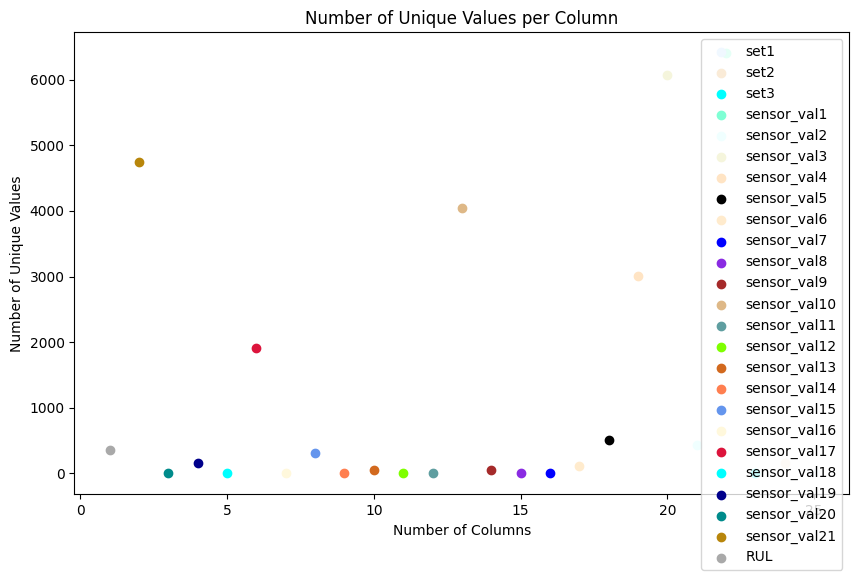

In [5]:
################################### Amount of unique values plot ##################################

# Drop irrelevant columns
columns_to_drop = ['engine_id', 'cycle']
df_unique = df.drop(columns_to_drop, axis=1)

# Count unique values per column
unique_value_counts = df_unique.nunique()

# Get colors for each column
# colors = plt.cm.plasma(range(len(unique_value_counts)))


# Get a list of all recognized color names
all_colors = list(mcolors.CSS4_COLORS.keys())

# Select the first 26 colors from the list
colors = all_colors[:26]

# Plot
plt.figure(figsize=(10, 6))
for i, (column, count) in enumerate(unique_value_counts.items()):
    plt.scatter(len(unique_value_counts) - i, count, color=colors[i], label=column)

# Add legend in the top-right corner
plt.legend(loc='upper right')

# Set labels and title
plt.xlabel('Number of Columns')
plt.ylabel('Number of Unique Values')
plt.title('Number of Unique Values per Column')

# Show plot
plt.show()


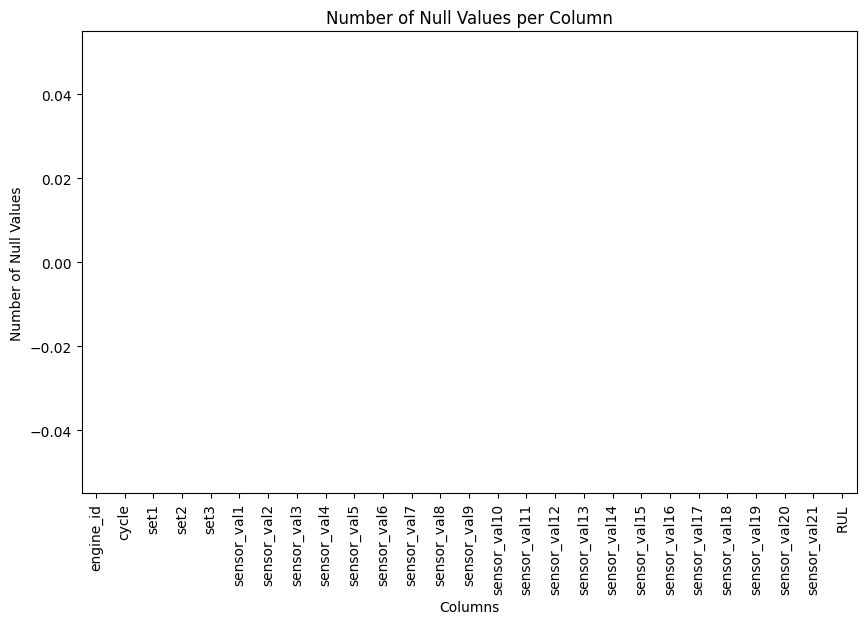

In [6]:
########################### Check amount of NULL values #########################################3

# Count null values per column
null_counts = df.isnull().sum()
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=null_counts.index, y=null_counts.values)

# Set labels and title
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Number of Null Values per Column')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show plot
plt.show()

In [7]:
# Checking the amount of unique values for features that do not have a correlation with any other variable
print(f"Unique values of settings 1: {df['set1'].unique()}")
print(f"Unique values of sensor 7: {df['sensor_val7'].unique()}")
print(f"Unique values of sensor 8: {df['sensor_val8'].unique()}")
print(f"Unique values of sensor 11: {df['sensor_val11'].unique()}")
print(f"unique values of the sensor 12: {len(df['sensor_val12'].unique())}")
print(f"Unique values of sensor 14: {df['sensor_val14'].unique()}")
print(f"Unique values of sensor 16: {df['sensor_val16'].unique()}")
print(f"Unique values of sensor 20: {df['sensor_val20'].unique()}")
print(f"unique values of the sensor 18: {df['sensor_val18'].unique()}")

Unique values of settings 1: [100.]
Unique values of sensor 7: [518.67]
Unique values of sensor 8: [0.03]
Unique values of sensor 11: [100.]
unique values of the sensor 12: 13
Unique values of sensor 14: [1.3]
Unique values of sensor 16: [2388]
Unique values of sensor 20: [14.62]
unique values of the sensor 18: [21.61 21.6 ]


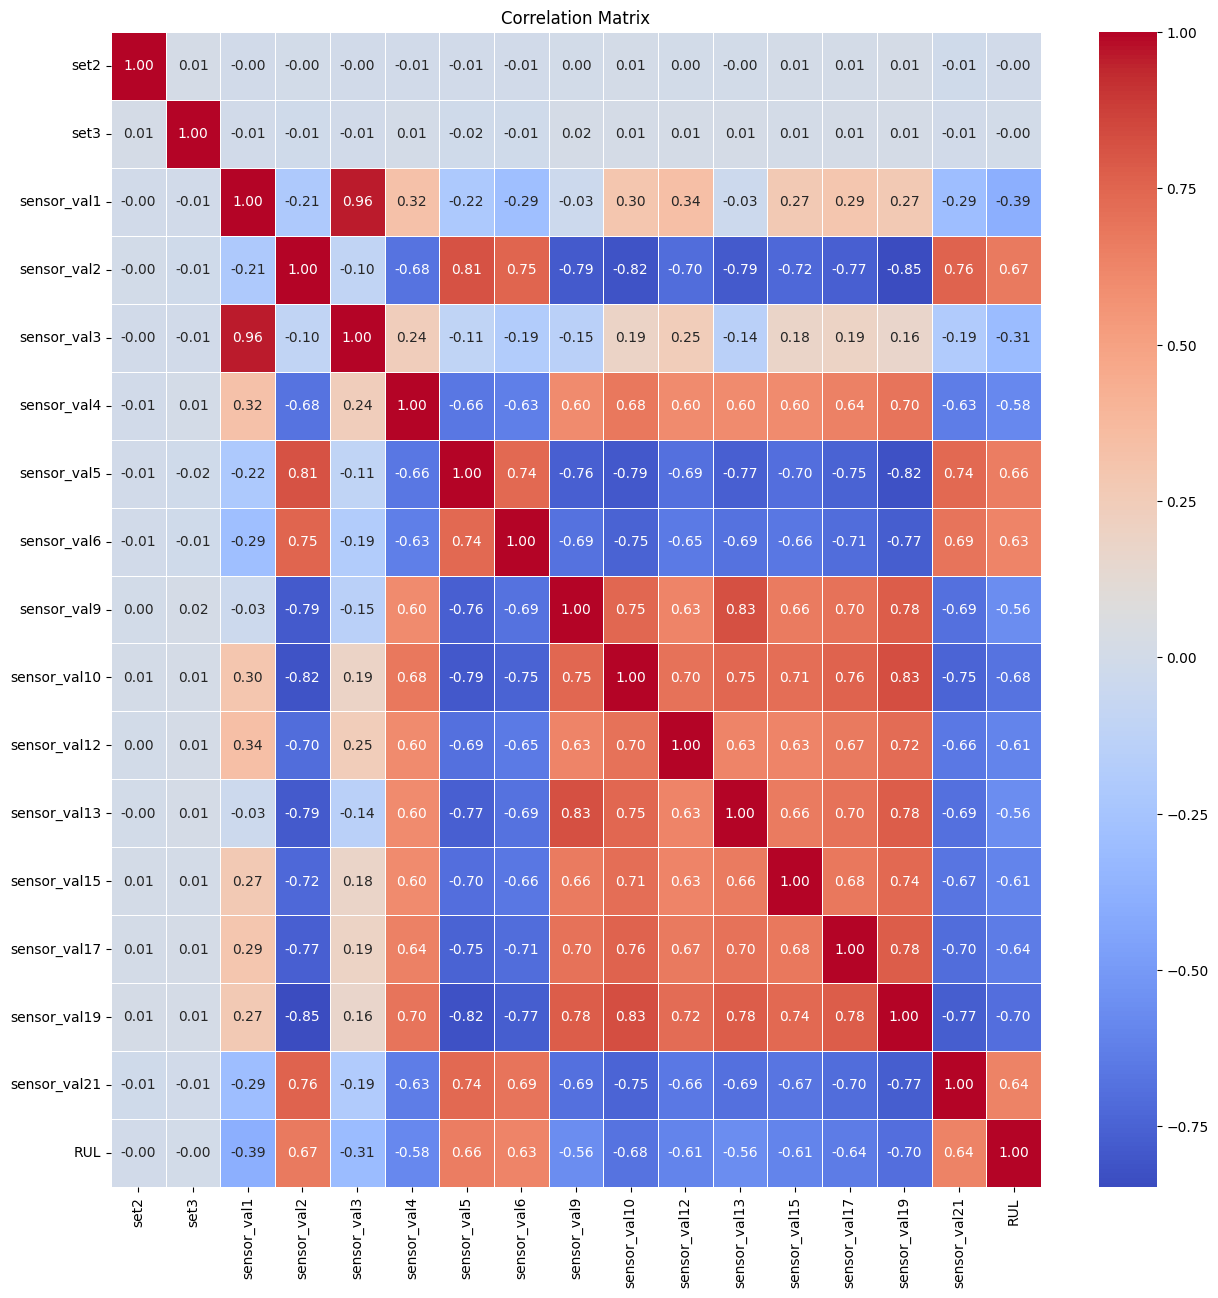

In [8]:
############ Correlation Matrix ######################
# Drop unnecessary columns for correlation analysis (e.g., engine_id, cycle)
columns_to_drop = ['engine_id', 'cycle','set1','sensor_val7','sensor_val8','sensor_val11','sensor_val14','sensor_val16','sensor_val18','sensor_val20']
df_corr = df.drop(columns_to_drop, axis=1)

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

######## Visualize correlation matrix #################

# Set the figure size
plt.figure(figsize=(15, 15))

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set title
plt.title('Correlation Matrix')

# Show plot
plt.show()

<Figure size 1200x800 with 0 Axes>

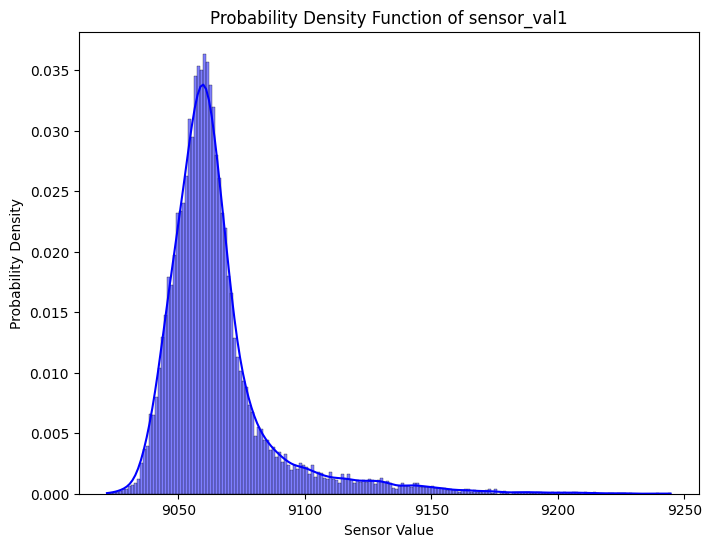

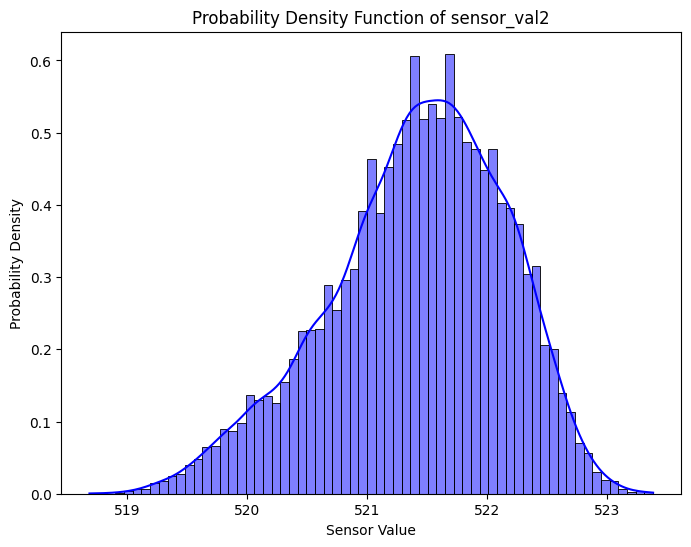

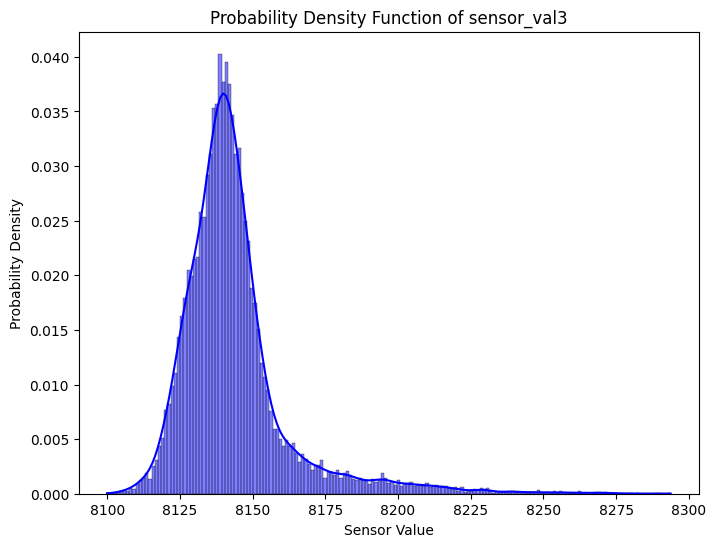

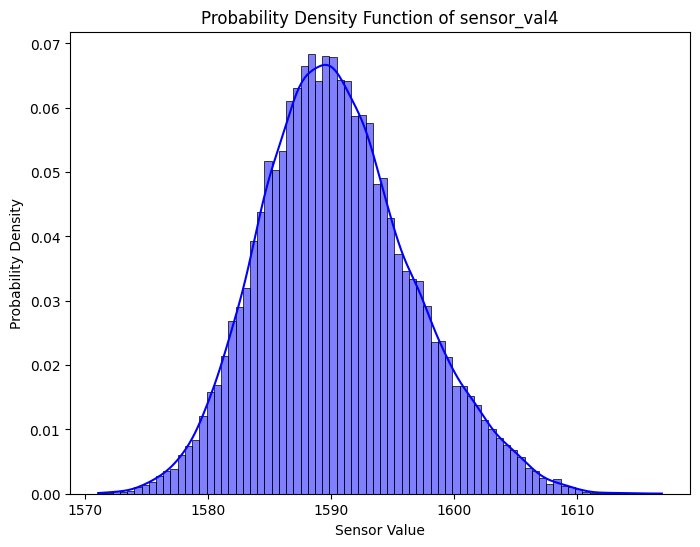

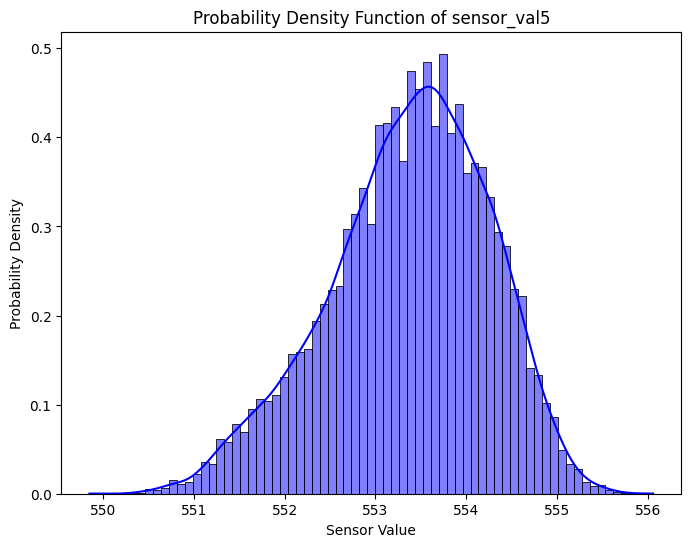

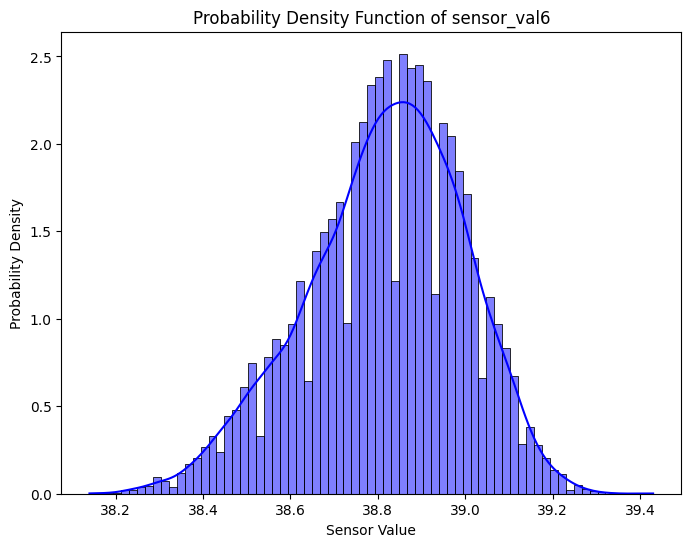

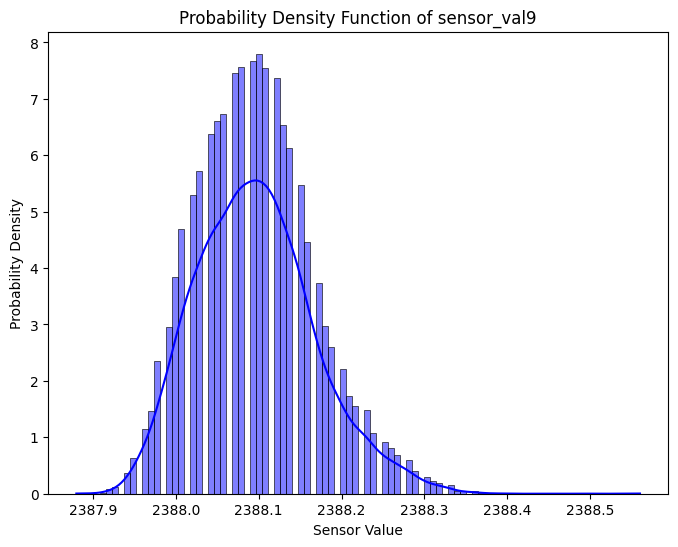

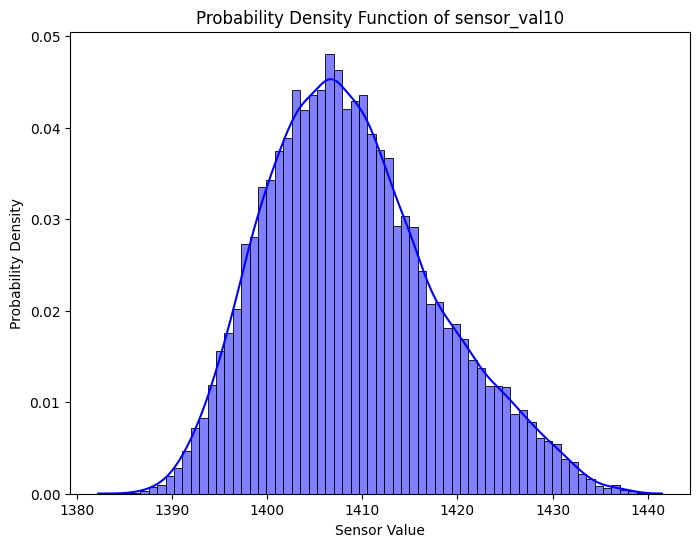

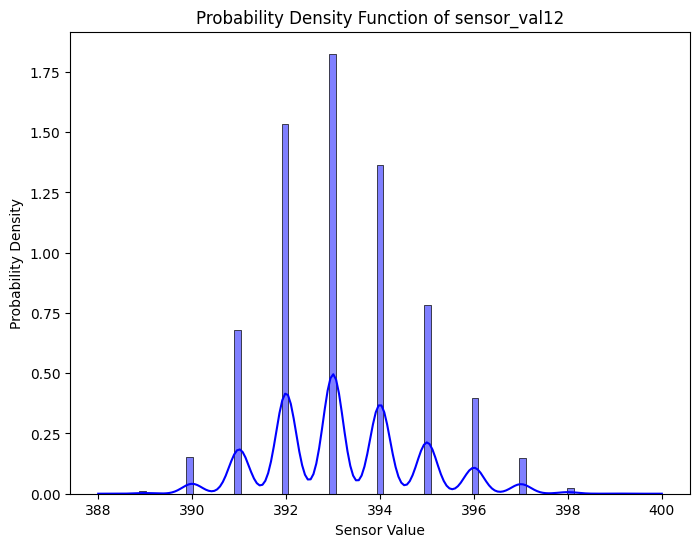

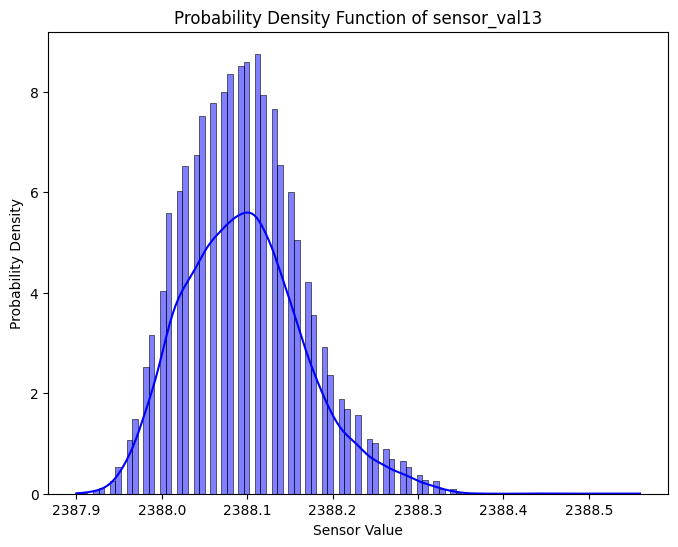

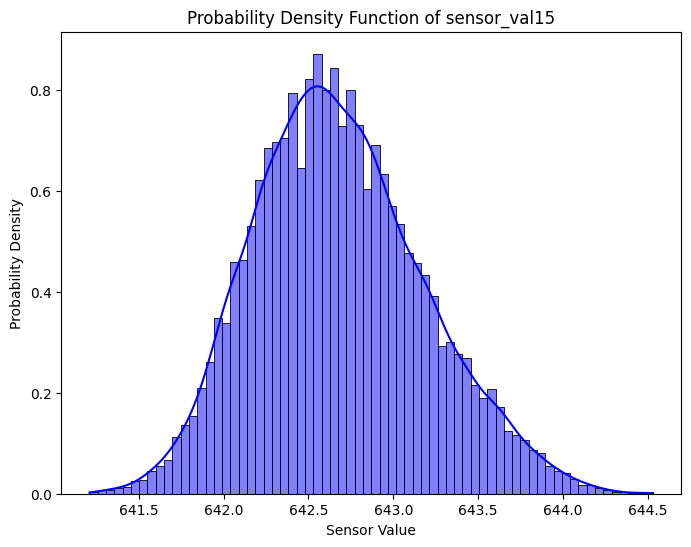

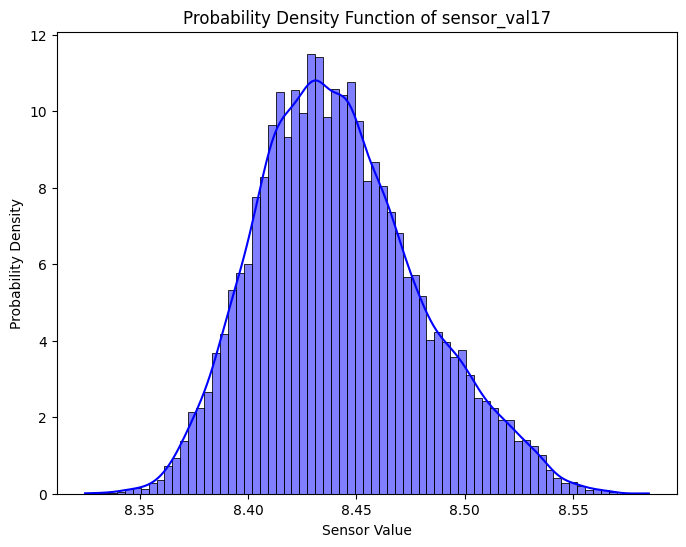

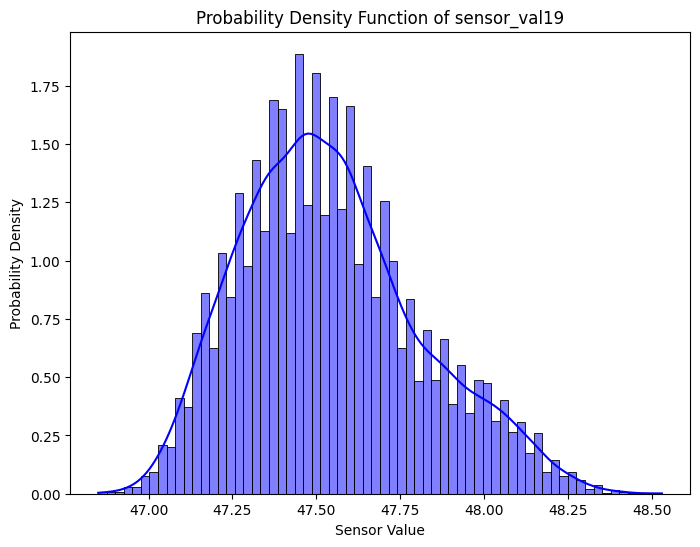

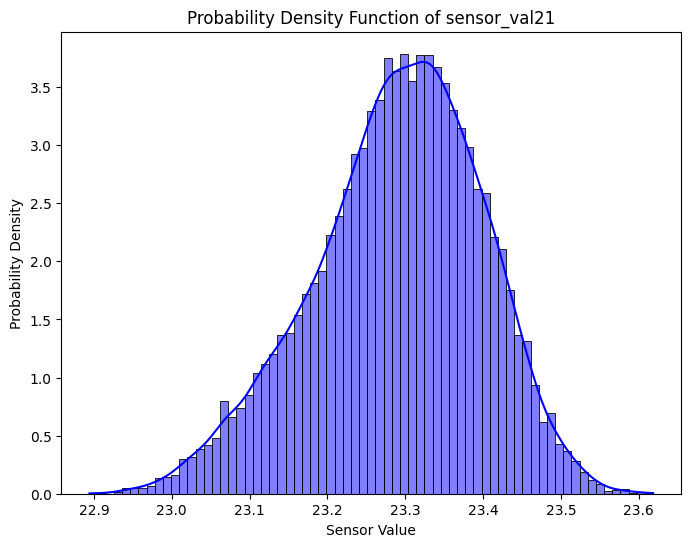

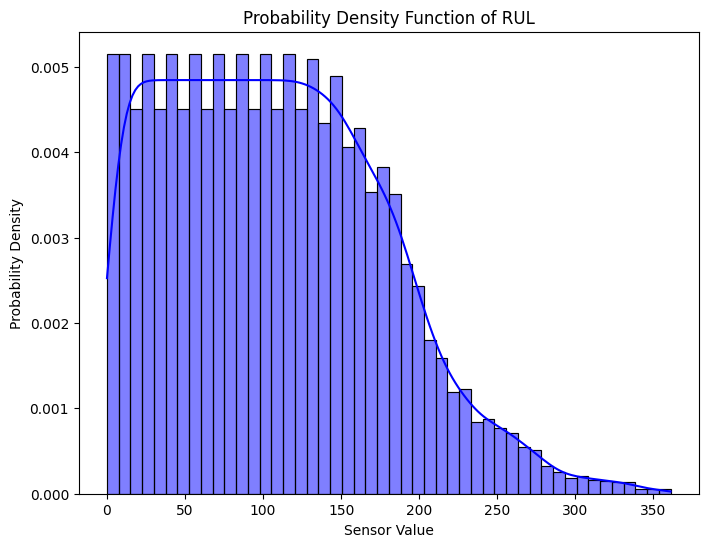

In [9]:
################################ PDF plots ###########################################
# Select only the sensor data columns
sensor_data = df_corr.iloc[:, 2:]

# Set figure size
plt.figure(figsize=(12, 8))

# Plot PDF for each sensor data feature
for column in sensor_data.columns:
    plt.figure(figsize=(8, 6))  # Create a new figure for each sensor data feature
    sns.histplot(sensor_data[column], kde=True, stat='density', color='blue', alpha=0.5)
    
    # Set title and labels
    plt.title(f'Probability Density Function of {column}')
    plt.xlabel('Sensor Value')
    plt.ylabel('Probability Density')
    
    # Show plot
    plt.show()


C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\836405268.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


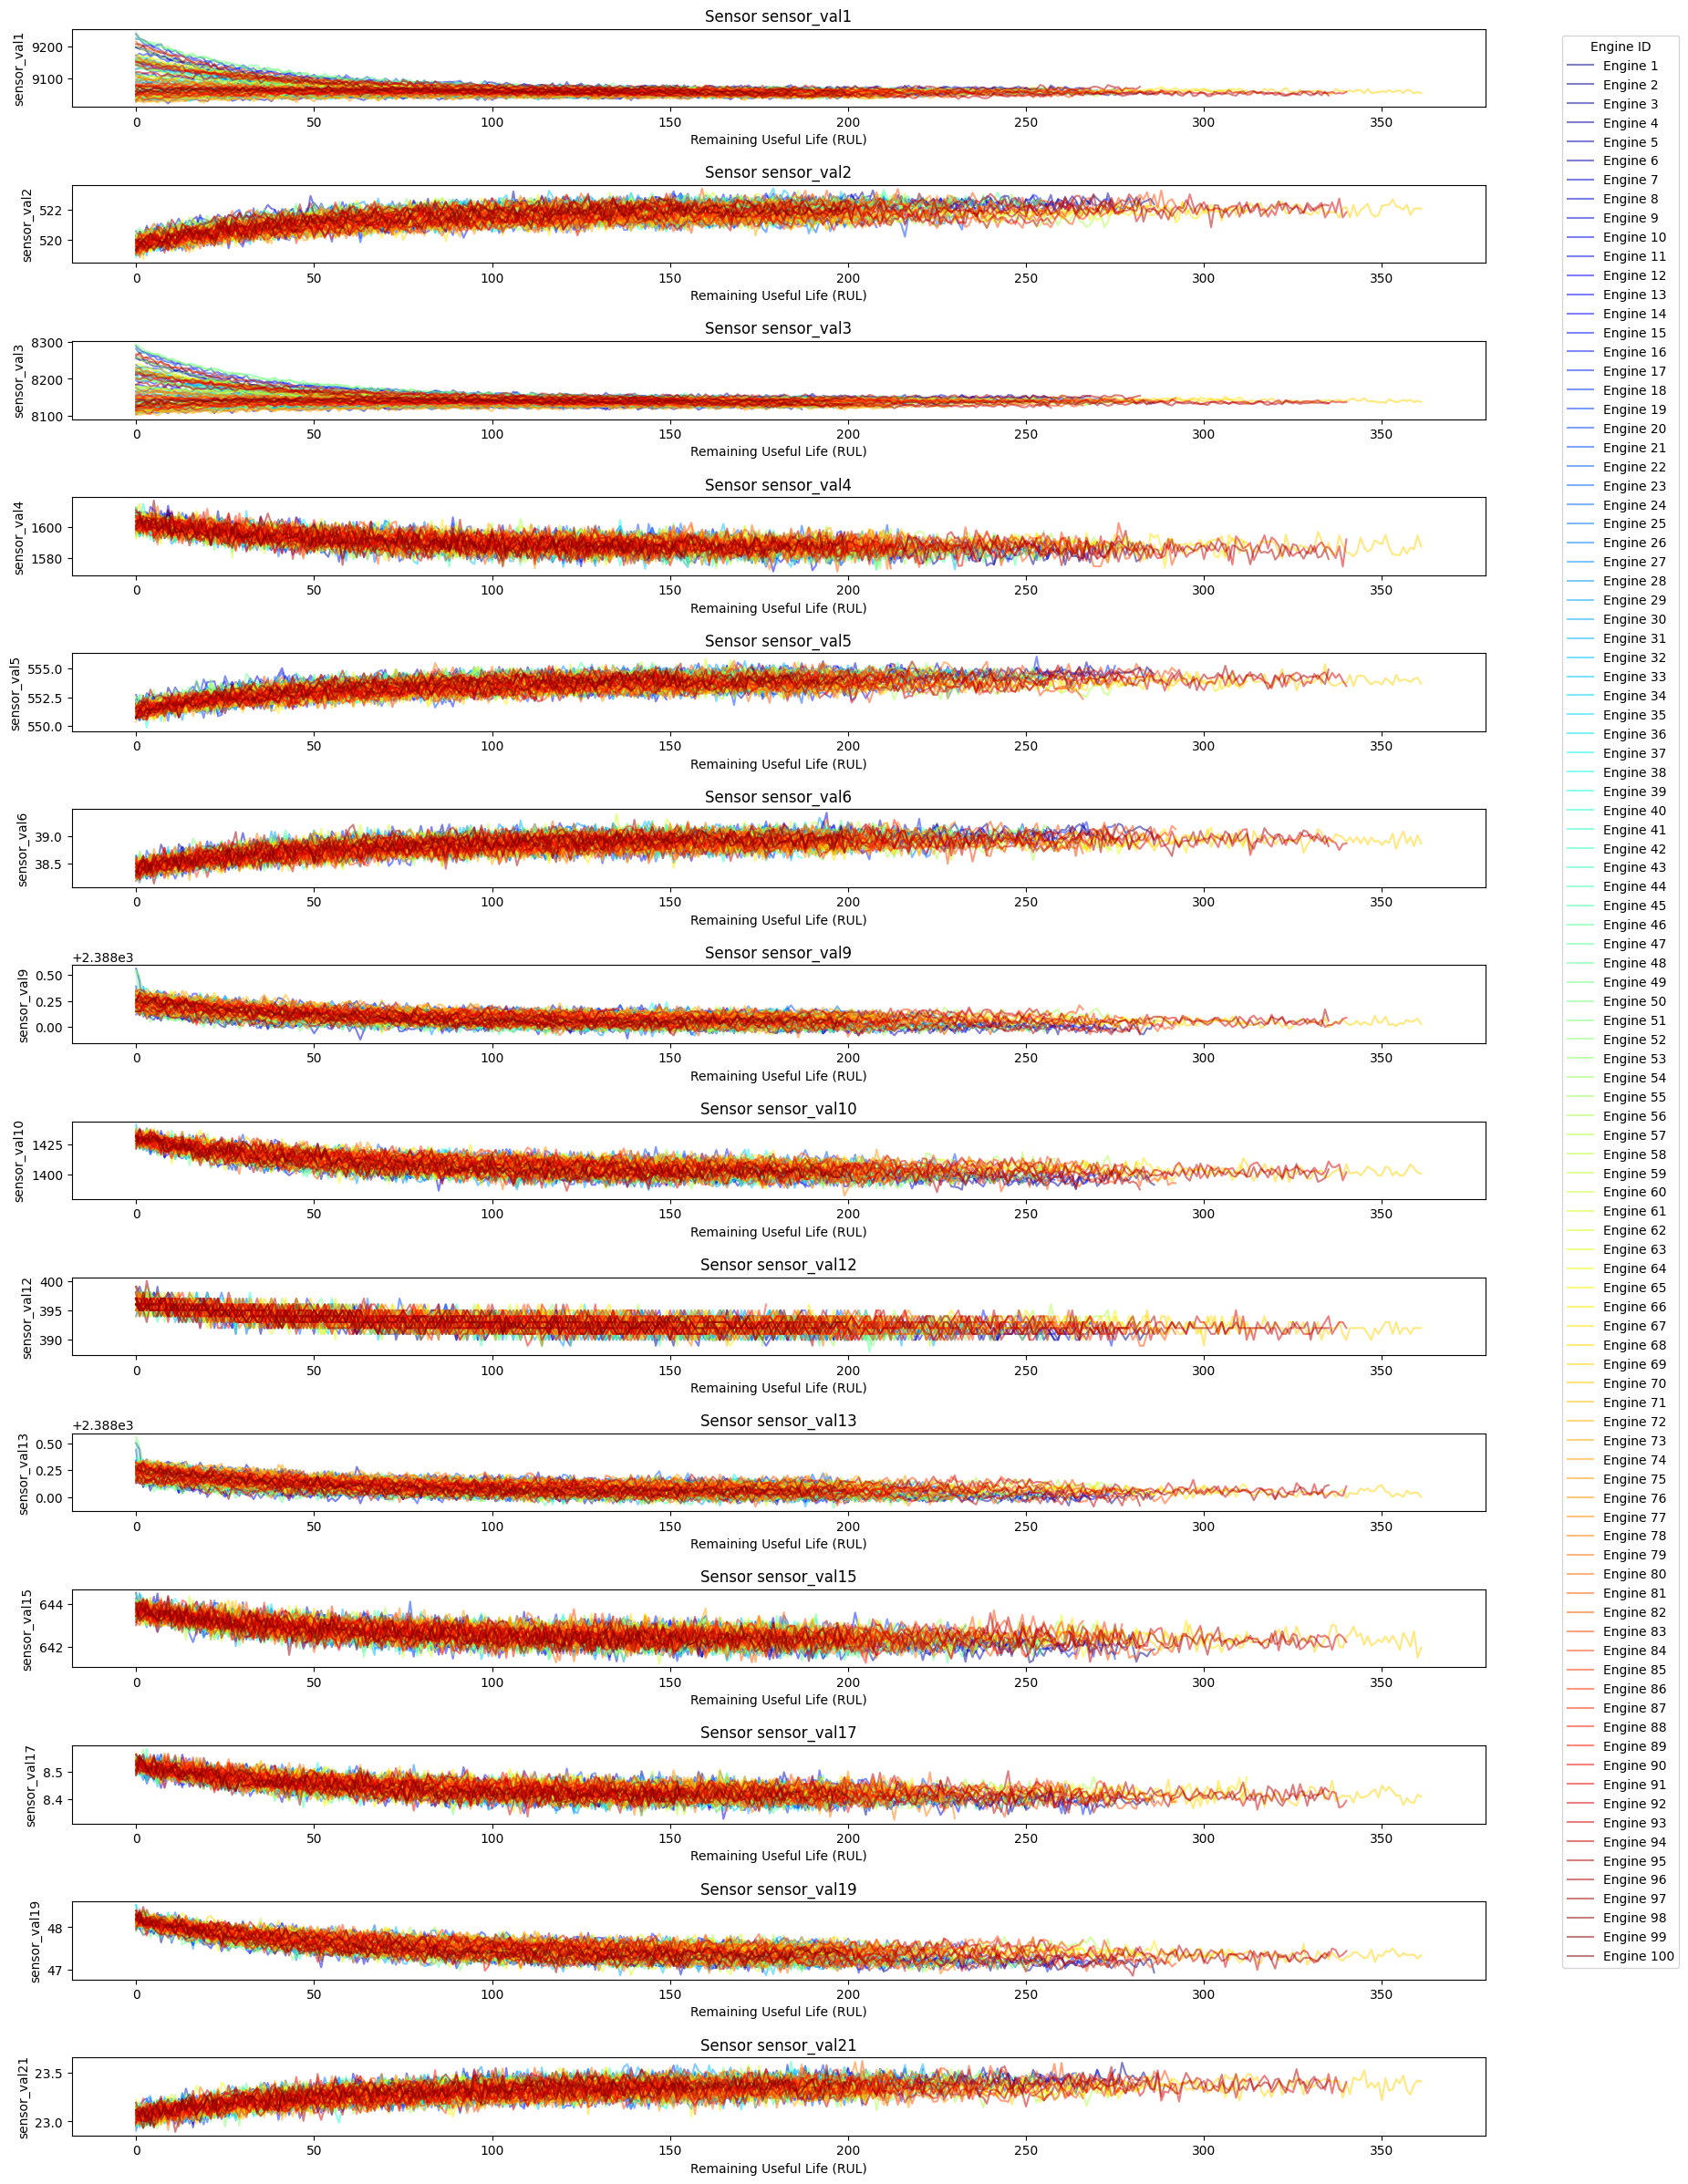

In [58]:
#################### Time series plot of all values ######################################
#### Conclusion sensor 1,3 are no good sensors because they are engine specific. All other sensors show a trend when the RUL decreased. ###

# Drop all previously dropped columns
columns_to_drop = ['cycle','set1','set2','set3','sensor_val7','sensor_val8','sensor_val11','sensor_val14','sensor_val16','sensor_val18','sensor_val20']
df_time_series_plot = df.drop(columns_to_drop, axis=1)

# Identify all sensor columns (you might need to adjust the names according to your dataset)
sensor_columns = [col for col in df_time_series_plot.columns if 'sensor_val' in col]

# Get a unique list of engines
engines = df_time_series_plot['engine_id'].unique()

# Generate a color map
colors = plt.cm.jet(np.linspace(0, 1, len(engines)))

plt.figure(figsize=(20, 30))  # Adjust the figure size as needed

for i, sensor in enumerate(sensor_columns, 1): # For all sensors 
    ax = plt.subplot(len(sensor_columns), 1, i)  # Creates a subplot for each sensor
    # Check when a sensor is an only one or no values
    if ax is None:
        print(f"Failed to create subplot for {sensor}")
        continue
    for engine, color in zip(engines, colors):
        # Filter data for one engine at a time
        engine_data = df_time_series_plot[df_time_series_plot['engine_id'] == engine]
        if engine_data.empty:
            # Check when an engine has no data
            print(f"No data for engine {engine}")
            continue
        # Plot the engine using specific requirements
        ax.plot(engine_data['RUL'], engine_data[sensor], linestyle='-', alpha = 0.5, color=color, label=f'Engine {engine}' if i == 1 else "")

    # Set the title and lables
    ax.set_title(f'Sensor {sensor}')
    ax.set_xlabel('Remaining Useful Life (RUL)')
    ax.set_ylabel(sensor)

    # Add legend to the first subplot only to avoid clutter
    if i == 1:
        plt.legend(title="Engine ID", bbox_to_anchor=(1.05, 1), loc='upper left')

# adjust spacing between subplots
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.show()

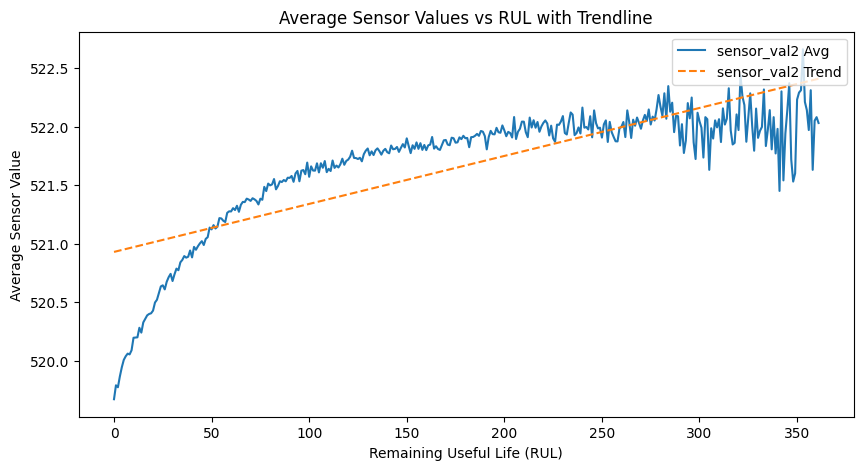

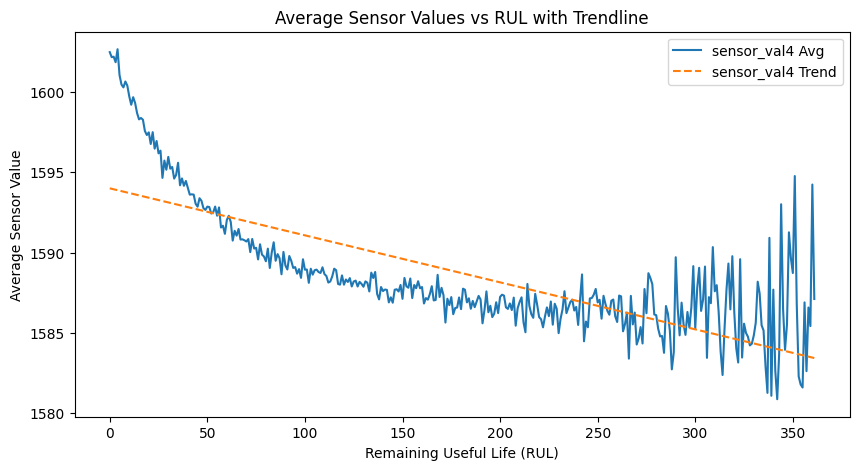

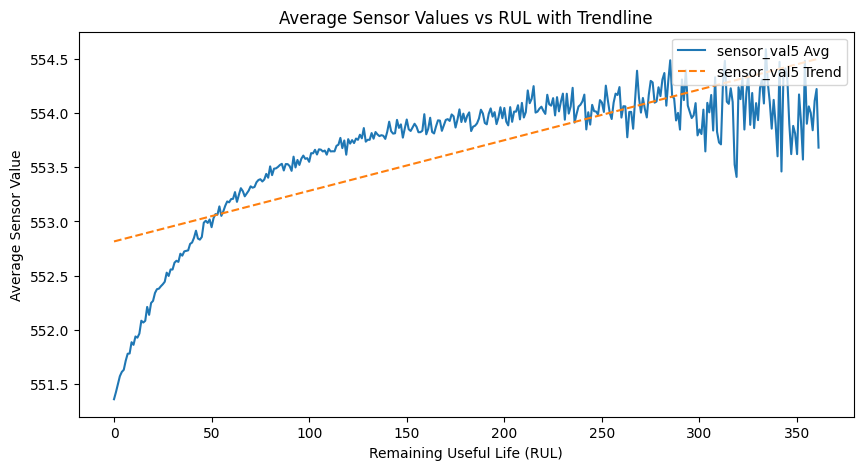

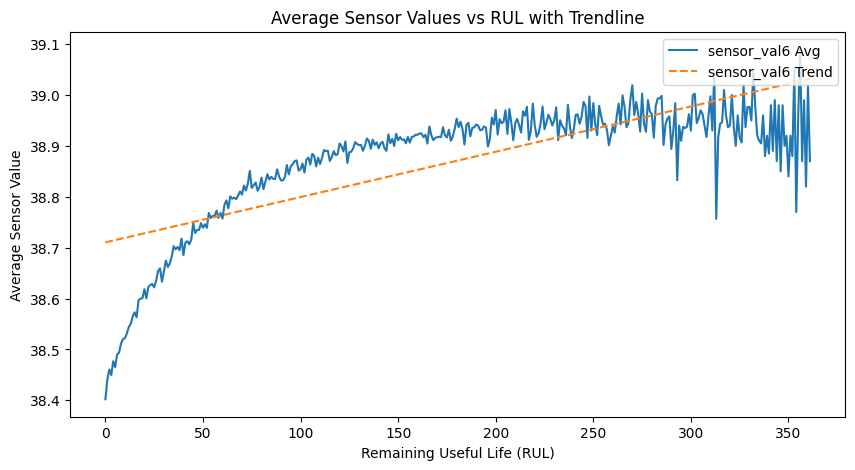

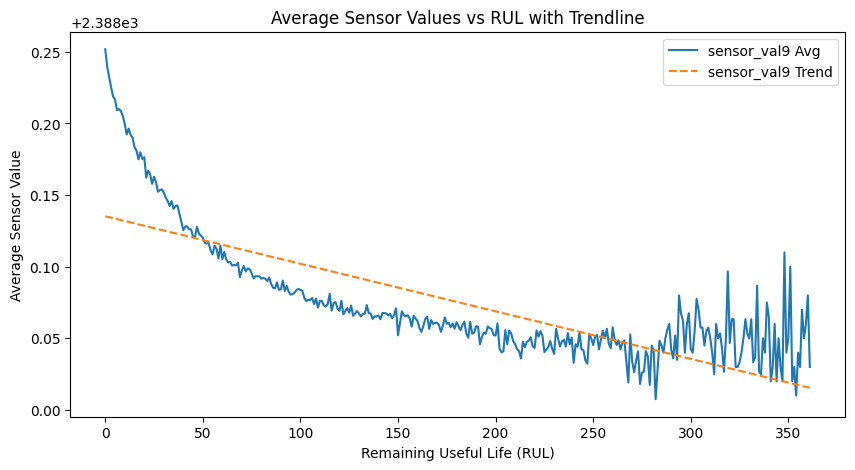

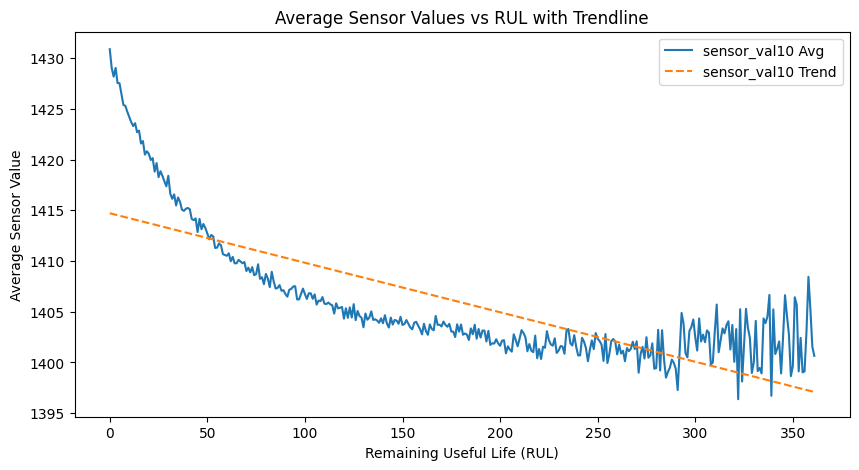

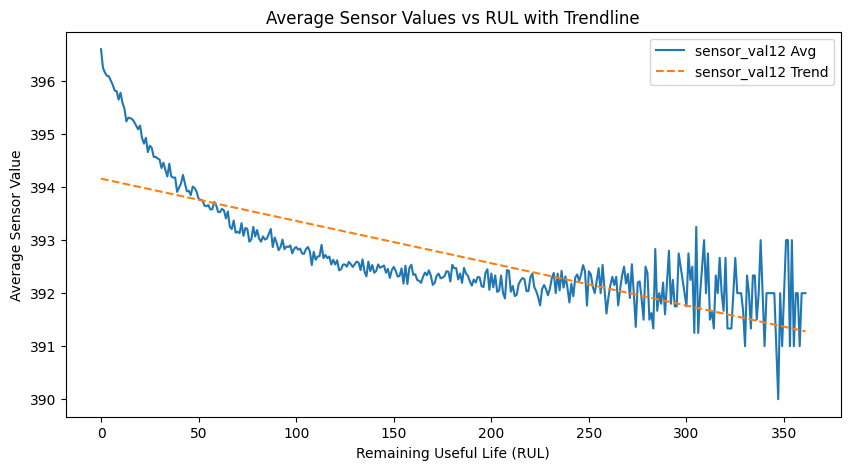

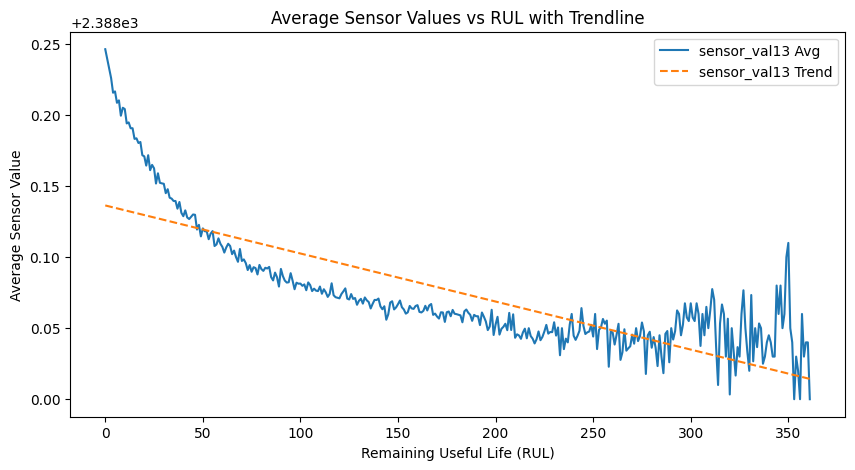

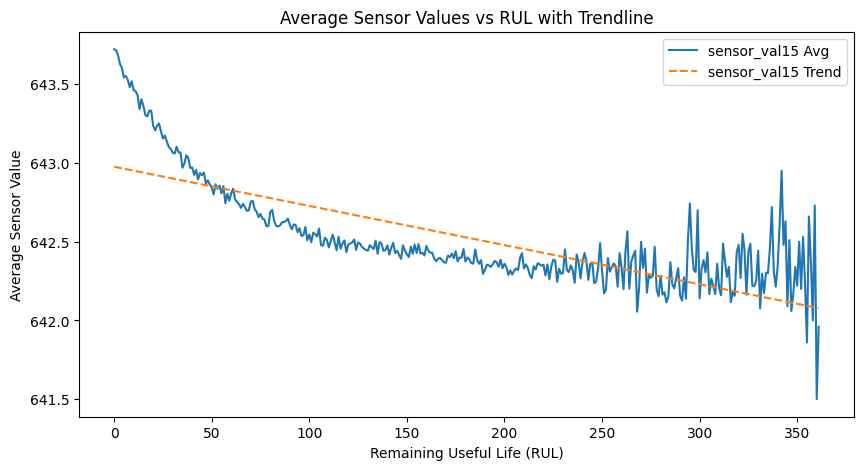

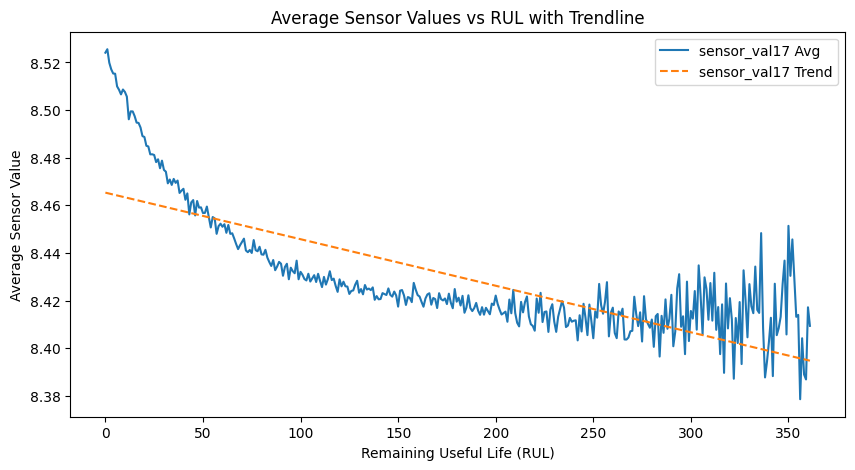

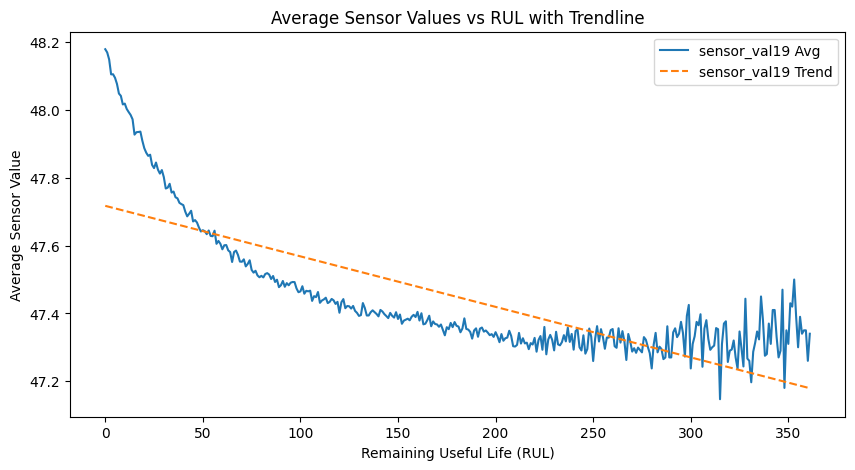

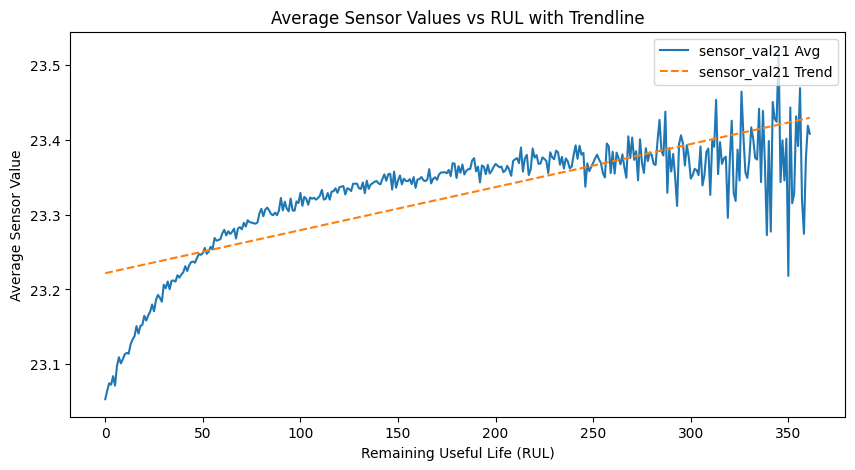

Top 5 sensors by absolute coefficient: [('sensor_val10', -0.04879479654332898), ('sensor_val4', -0.029322032355207993), ('sensor_val12', -0.00797809232913952), ('sensor_val5', 0.004665341071946685), ('sensor_val2', 0.004097047204832277)]


In [96]:
################# Linear Regression #############################
# Example to load your data
columns_to_drop = ['engine_id', 'cycle','set1','set2','set3','sensor_val1', 'sensor_val3','sensor_val7','sensor_val8','sensor_val11','sensor_val14','sensor_val16','sensor_val18','sensor_val20']
df_regression = df.drop(columns_to_drop, axis=1)

# Identify all sensor columns
sensor_columns = [col for col in df_regression.columns if 'sensor_val' in col]

# Calculate average sensor values per RUL
average_per_rul = df_regression.groupby('RUL')[sensor_columns].mean().reset_index()


coefficients = {}

for sensor in sensor_columns:
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(average_per_rul['RUL'], average_per_rul[sensor])
    coefficients[sensor] = slope  # Store the slope for later use

    # Calculate trendline
    trendline = intercept + slope * average_per_rul['RUL']

    plt.figure(figsize=(10, 5))  # Adjust the figure size as needed

    # Plotting
    plt.plot(average_per_rul['RUL'], average_per_rul[sensor], label=f'{sensor} Avg', linestyle='-')
    plt.plot(average_per_rul['RUL'], trendline, label=f'{sensor} Trend', linestyle='--')

    plt.title(f'Average Sensor Values vs RUL with Trendline')
    plt.xlabel('Remaining Useful Life (RUL)')
    plt.ylabel('Average Sensor Value')
    plt.legend(loc='upper right')
    plt.show()

# Find the top 5 sensors by the absolute value of their coefficients
top_sensors = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
print("Top 5 sensors by absolute coefficient:", top_sensors)

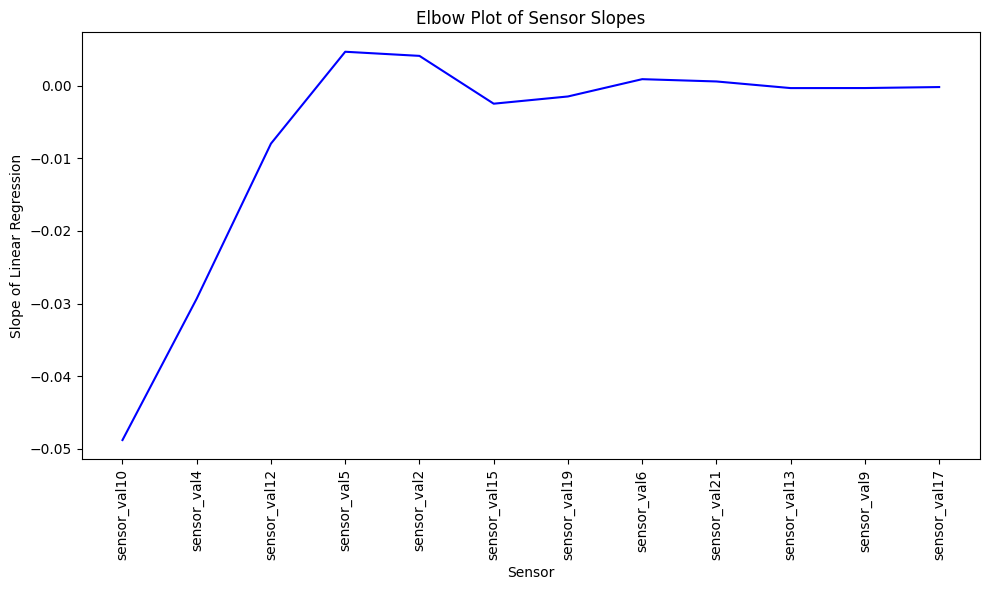

In [75]:
# load the data
columns_to_drop = ['engine_id', 'cycle','set1','set2','set3','sensor_val1', 'sensor_val3','sensor_val7','sensor_val8','sensor_val11','sensor_val14','sensor_val16','sensor_val18','sensor_val20']
df_regression = df.drop(columns_to_drop, axis=1)

# Identify all sensor columns
sensor_columns = [col for col in df_regression.columns if 'sensor_val' in col]

# Calculate average sensor values per RUL
average_per_rul = df_regression.groupby('RUL')[sensor_columns].mean().reset_index()

coefficients = {}

for sensor in sensor_columns:
    # Fit linear regression
    slope, intercept, r_value, p_value, std_err = linregress(average_per_rul['RUL'], average_per_rul[sensor])
    coefficients[sensor] = slope  # Store the slope

# Sort sensors by the absolute value of their coefficients in descending order
sorted_sensors = sorted(coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
x_labels = [item[0] for item in sorted_sensors]  # Sensor names
y_values = [item[1] for item in sorted_sensors]  # Corresponding slopes

plt.plot(x_labels, y_values, color='blue')
plt.xticks(rotation=90)  # Rotate sensor names for better visibility
plt.xlabel('Sensor')
plt.ylabel('Slope of Linear Regression')
plt.title('Elbow Plot of Sensor Slopes')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

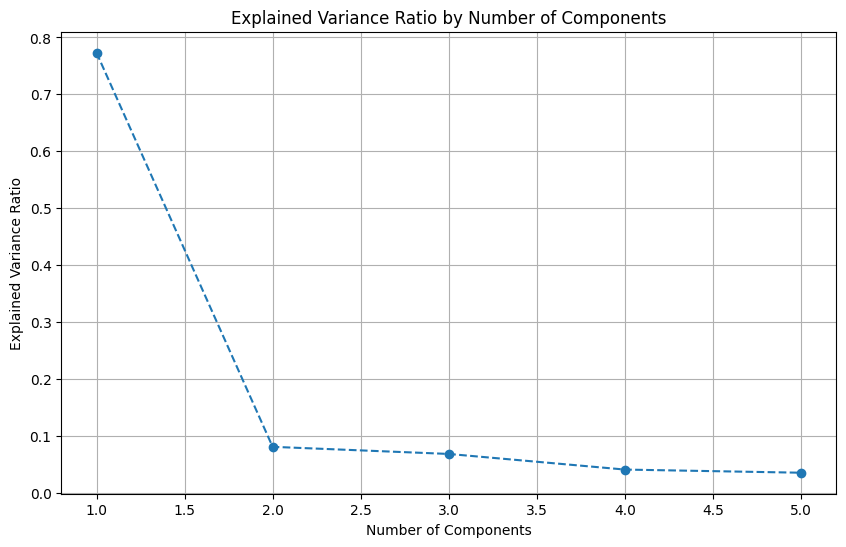

In [97]:
############################## PCA ########################################
# Drop unnecessary columns for the PCA analysis only include the sensor data after the correlation analysis (e.g., engine_id, cycle,set1,set2,set3)
columns_to_select = ["sensor_val10",'sensor_val4','sensor_val12','sensor_val5','sensor_val2']
df_pca = df[columns_to_select]
df_pca
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

# Initialize PCA
pca = PCA()

# Fit PCA
pca.fit(scaled_data)


# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Number of Components')
plt.grid(True)
plt.show()

In [94]:
####################### Make Table for PCA analysis ##############################################
# Initialize DataFrame to store probabilities
explained_ratio_df = pd.DataFrame({
    'Number of Components': range(1, len(pca.explained_variance_ratio_) + 1),
    'Explained Variance Ratio': pca.explained_variance_ratio_.round(2)
})

# Calculate cumulative explained variance
explained_ratio_df['Cumulative Explained Variance'] = explained_ratio_df['Explained Variance Ratio'].cumsum().round(2)

# Print the DataFrame
print(explained_ratio_df)


   Number of Components  Explained Variance Ratio  \
0                     1                      0.77   
1                     2                      0.08   
2                     3                      0.07   
3                     4                      0.04   
4                     5                      0.04   

   Cumulative Explained Variance  
0                           0.77  
1                           0.85  
2                           0.92  
3                           0.96  
4                           1.00  


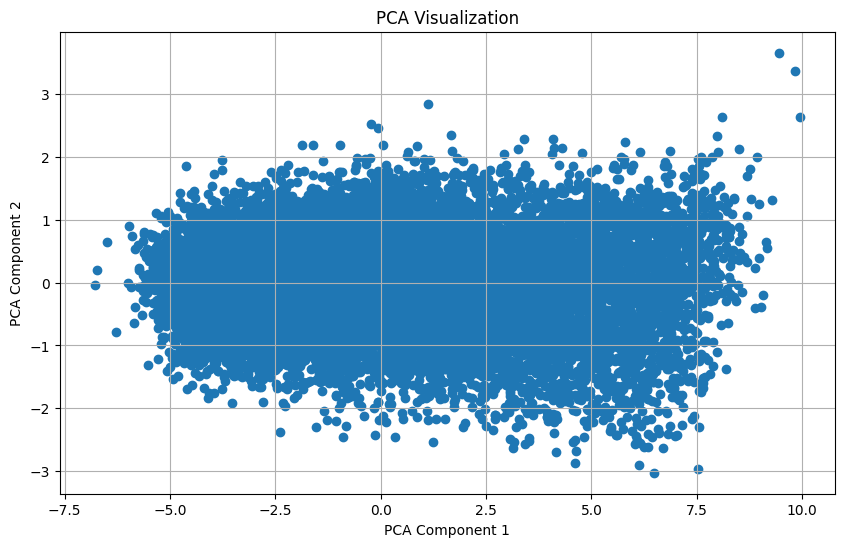

In [64]:
################# PCA Plot ######################################
# Transform the scaled data using the first two principal components
pca_data = pca.transform(scaled_data)[:, :2]

# Plot PCA data
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.title('PCA Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Predicitive model

In [119]:
############################ Train-Test-split #########################
columns_to_select = ["RUL","engine_id","sensor_val10",'sensor_val4','sensor_val12','sensor_val5','sensor_val2']

df_clean = df[columns_to_select]

sensor_columns = [col for col in df_clean.columns if 'sensor_val' in col]
engines = df_clean['engine_id'].unique()
np.random.shuffle(engines) 

float_index = len(engines) * 0.8
split_index = int(round(float_index,0))

train_engines = engines[:split_index]
test_engines = engines[split_index:]

# Create train and test datasets
train_df = df_clean[df_clean["engine_id"].isin(train_engines)]
test_df = df_clean[df_clean["engine_id"].isin(test_engines)]

# create X and y_train
X_train = train_df[sensor_columns]
y_train = train_df["RUL"]

# create X and y test
X_test = test_df[sensor_columns]
y_test = test_df["RUL"]

# ids_train and test
ids_train = train_df["engine_id"]
ids_test = test_df["engine_id"]


In [175]:
############################## SKlearn Pipeline #####################################

# Create a pipeline with StandardScaler, PCA, and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('pca', PCA(n_components=3)),  # PCA for dimensionality reduction, keeping the first 3 components
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,max_features="log2",max_depth=10))  # RandomForestClassifier with initial hyperparameters
])

pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('rf',
                 RandomForestRegressor(max_depth=10, max_features='log2',
                                       random_state=42))])

In [176]:
##################### First initial fitting round
# Fit the pipeline on the training data
pipeline.fit(X_train,y_train)

# predict the RUL on the test set
test_df["predicted_RUL"] = pipeline.predict(X_test)

# create the weights: later RUL get a higher priority of being chosen, latest information
test_df["Weights"] = np.exp(-0.1 * (test_df["RUL"]-test_df["predicted_RUL"]))

# Calculate the weighted average prediction:
weighted_rul_predictions = test_df.groupby('engine_id').apply(
    lambda x: int(round(np.average(x['predicted_RUL'], weights=x["Weights"]),0))
).reset_index(name="Weighted_prediction_RUL")
# Create a list of tuples (engine_id,RUL)

sorted_weighted_RUL_predictions = weighted_rul_predictions.sort_values(by= 'engine_id')

print(sorted_weighted_RUL_predictions)

    engine_id  Weighted_prediction_RUL
0           5                      129
1          11                      130
2          21                      123
3          22                       58
4          23                      111
5          28                      138
6          31                      127
7          32                       93
8          37                      123
9          43                      130
10         46                      125
11         48                      133
12         74                      168
13         77                      124
14         86                       93
15         88                      118
16         90                      136
17         93                      136
18         96                      107
19         99                      127


C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\3047943495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_RUL"] = pipeline.predict(X_test)
C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\3047943495.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Weights"] = np.exp(-0.1 * (test_df["RUL"]-test_df["predicted_RUL"]))
C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\3047943495.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavi

In [ ]:
######## Make Scorer function based on weigted SSD ##############
def exponential_weighted_mse(y_true, y_pred):
    """Calculate MSE with exponential weights based on RUL."""
    # RUL is inverse of index (i.e., as index goes up, RUL goes down)
    weights = np.exp(-0.01 * (np.max(y_true) - y_true))  # Adjust the 0.1 factor as needed
    return np.average((y_true - y_pred) ** 2, weights=weights)

# Create a scorer that can be used with scikit-learn models
weighted_mse_scorer = make_scorer(exponential_weighted_mse, greater_is_better=False)

In [160]:
######################################## Hyperparameter tuning #########################################
# Define hyperparameters grid for RandomizedSearchCV
param_grid_random = {
    'pca__n_components': [1,3, 5],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [5, 10, 15],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth' : [3,6,11]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid_random, n_iter=10, scoring=weighted_mse_scorer, cv=5, random_state=42,error_score='raise',n_jobs=-1)
random_search.fit(X_train,y_train)

# Get the best estimator and parameters from RandomizedSearchCV
best_estimator_random = random_search.best_estimator_
best_params_random = random_search.best_params_

print("Best Parameters from RandomizedSearchCV:", best_params_random)

Best Parameters from RandomizedSearchCV: {'rf__n_estimators': 150, 'rf__max_features': 'log2', 'rf__max_depth': 11, 'pca__n_components': 1}


In [161]:
# Define hyperparameters grid for GridSearchCV
param_grid_grid = {
    'pca__n_components': [best_params_random['pca__n_components']],
    'rf__n_estimators': [best_params_random['rf__n_estimators'] - 10, best_params_random['rf__n_estimators'], best_params_random['rf__n_estimators'] + 10],
    'rf__max_depth': [best_params_random['rf__max_depth'] - 2, best_params_random['rf__max_depth'], best_params_random['rf__max_depth'] + 2],
    'rf__max_features': [best_params_random['rf__max_features']]
}

# Perform GridSearchCV with parallel computing
grid_search = GridSearchCV(pipeline, param_grid=param_grid_grid, scoring=weighted_mse_scorer, cv=5, n_jobs=-1,error_score='raise')
grid_search.fit(X, y)

# Get the best estimator and parameters from GridSearchCV
best_estimator_grid = grid_search.best_estimator_
best_params_grid = grid_search.best_params_

print("Best Parameters from GridSearchCV:", best_params_grid)

Best Parameters from GridSearchCV: {'pca__n_components': 1, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__n_estimators': 140}


In [177]:
############################## SKlearn Pipeline After tuning #####################################
# Create a pipeline with StandardScaler, PCA, and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('pca', PCA(n_components=best_params_grid["pca__n_components"])),  # PCA for dimensionality reduction, keeping the first 3 components
    ('rf', RandomForestRegressor(n_estimators=best_params_grid['rf__n_estimators'], random_state=42,
                                 max_features=best_params_grid["rf__max_features"],max_depth=best_params_grid["rf__max_depth"]))  # RandomForestClassifier with initial hyperparameters
])

pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=1)),
                ('rf',
                 RandomForestRegressor(max_depth=9, max_features='log2',
                                       n_estimators=140, random_state=42))])

In [178]:
###################################### Initial model training ######################################

# Fit the pipeline to your training data
pipeline.fit(X_train, y_train)

# predict the RUL on the test set
test_df["predicted_RUL"] = pipeline.predict(X_test)

# create the weights: later RUL get a higher priority of being chosen, latest information
test_df["Weights"] = np.exp(-0.1 * (test_df["RUL"]-test_df["predicted_RUL"]))

# Calculate the weighted average prediction:
weighted_rul_predictions = test_df.groupby('engine_id').apply(
    lambda x: int(round(np.average(x['predicted_RUL'], weights=x["Weights"]),0))
).reset_index(name="Weighted_prediction_RUL")
# Create a list of tuples (engine_id,RUL)

sorted_weighted_RUL_predictions = weighted_rul_predictions.sort_values(by= 'engine_id')

print(sorted_weighted_RUL_predictions)


    engine_id  Weighted_prediction_RUL
0           5                      145
1          11                      135
2          21                      121
3          22                       74
4          23                      112
5          28                      152
6          31                      134
7          32                       89
8          37                      125
9          43                      140
10         46                      128
11         48                      133
12         74                      137
13         77                      118
14         86                       97
15         88                      120
16         90                      147
17         93                      144
18         96                      104
19         99                      130


C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\3032948928.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predicted_RUL"] = pipeline.predict(X_test)
C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\3032948928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Weights"] = np.exp(-0.1 * (test_df["RUL"]-test_df["predicted_RUL"]))
C:\Users\Marijn\AppData\Local\Temp\ipykernel_5928\3032948928.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behav

In [182]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring=weighted_mse_scorer,n_jobs=-1)

# Convert scores to positive values
cv_scores = -cv_scores

# Print mean and standard deviation of cross-validation scores
print("Mean Cross-Validation Weigted MSE:", np.mean(cv_scores))
print("Standard Deviation of Cross-Validation Weighted MSE:", np.std(cv_scores))

Mean Cross-Validation Weigted MSE: 12318.62586727992
Standard Deviation of Cross-Validation Weighted MSE: 9619.25210053191
